In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/NarutoUchiha39/AMLProject.git

Cloning into 'AMLProject'...
remote: Enumerating objects: 10155, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 10155 (delta 3), reused 38 (delta 2), pack-reused 10111 (from 2)
Receiving objects: 100% (10155/10155), 110.71 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (10067/10067), done.


In [3]:
cd /content/AMLProject

/content/AMLProject


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc
import optuna
import logging

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
data = pd.read_csv('HAM10000_metadata.csv')
path = os.path.join("DLModel","segmented_images")

dict1 = {"image_path":[]}
for i in data.columns.values:
    dict1[i] = list(data[i])

for i in dict1["image_id"]:
    dict1["image_path"].append(os.path.join("DLModel","segmented_images",i+".jpg"))

In [19]:
oneHot = OneHotEncoder()
l = []
res = oneHot.fit_transform(data["dx"].to_frame()).toarray()
for i in res:
    l.append(i.argmax())

dict1["dx_cat"] = l
data = pd.concat([pd.Series(v,name=k) for k,v in dict1.items()],axis=1)

In [20]:
data

,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,DLModel/segmented_images/ISIC_0027419.jpg,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,DLModel/segmented_images/ISIC_0025030.jpg,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,DLModel/segmented_images/ISIC_0026769.jpg,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,DLModel/segmented_images/ISIC_0025661.jpg,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,DLModel/segmented_images/ISIC_0031633.jpg,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...,...
10010,DLModel/segmented_images/ISIC_0033084.jpg,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,DLModel/segmented_images/ISIC_0033550.jpg,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,DLModel/segmented_images/ISIC_0033536.jpg,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,DLModel/segmented_images/ISIC_0032854.jpg,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


# Preprocessing

**Normalize function**

In [21]:
img_h, img_w = 224, 224

In [22]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [23]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [24]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [25]:
data.head()

,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,DLModel/segmented_images/ISIC_0027419.jpg,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,DLModel/segmented_images/ISIC_0025030.jpg,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,DLModel/segmented_images/ISIC_0026769.jpg,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,DLModel/segmented_images/ISIC_0025661.jpg,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,DLModel/segmented_images/ISIC_0031633.jpg,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


**Data Loading**

In [26]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [27]:
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 4006 Val: 4006 Test: 2003


**Batch check**

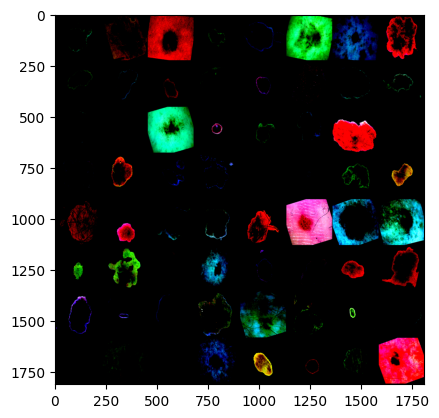

Labels:  tensor([2, 5, 5, 5, 5, 1, 5, 4, 5, 5, 5, 5, 5, 2, 5, 1, 2, 5, 5, 3, 5, 4, 5, 5,
        4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 2, 5, 5, 2, 1, 2, 0, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 4, 0, 5, 5, 4, 5, 6, 5, 5, 5, 5, 5, 5])


In [28]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Hyperparameter tunning

Balanced subsample split

In [30]:
selected_data = data.groupby('dx').apply(lambda x: x.sample(n=110)).reset_index(drop=True)
selected_data.head()

<ipython-input-30-3e41fd163610>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_data = data.groupby('dx').apply(lambda x: x.sample(n=110)).reset_index(drop=True)


,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,DLModel/segmented_images/ISIC_0027678.jpg,HAM_0003586,ISIC_0027678,akiec,histo,60.0,male,back,0
1,DLModel/segmented_images/ISIC_0030175.jpg,HAM_0003051,ISIC_0030175,akiec,histo,85.0,female,upper extremity,0
2,DLModel/segmented_images/ISIC_0031922.jpg,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,0
3,DLModel/segmented_images/ISIC_0031211.jpg,HAM_0004563,ISIC_0031211,akiec,histo,75.0,male,lower extremity,0
4,DLModel/segmented_images/ISIC_0024654.jpg,HAM_0005705,ISIC_0024654,akiec,histo,75.0,female,lower extremity,0


In [31]:
class CNNet_trial(nn.Module):
    def __init__(self, num_filters, num_classes, num_of_layers):
        super(CNNet_trial, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3
        for out_channels in num_filters:
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))
            in_channels = out_channels

        self.flat_features = int(num_filters[-1] * (224/2**num_of_layers) * (224/2**num_of_layers))
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
train_val_trial, test_trial = train_test_split(selected_data, test_size=0.2, random_state=42)

train_trial, val_trial = train_test_split(selected_data, test_size=0.5, random_state=42)

train_trial = HAM10000Dataset(train_trial, transform=transform)
val_trial = HAM10000Dataset(val_trial, transform=transform)
test_trial = HAM10000Dataset(test_trial, transform=transform)

batch_size = 64
num_workers = 5

train_loader_trial = DataLoader(train_trial, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_trial = DataLoader(val_trial, batch_size=batch_size, num_workers=num_workers)
test_loader_trial = DataLoader(test_trial, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_trial), 'Val:', len(val_trial), 'Test:', len(test_trial))

Data len Train: 385 Val: 385 Test: 154


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Set the optuna parameters**

In [33]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    num_of_layers = trial.suggest_int('num_of_layers', 3, 4)
    if num_of_layers == 4:
        num_filters = trial.suggest_categorical('num_filters_4_layers', [[16, 32, 64, 128], [32, 64, 128, 256], [64, 128, 256, 512], [16, 32, 128, 512],
                                                                          [32, 32, 64, 256], [32, 128, 256, 256], [32, 128, 128, 256], [128, 256, 512, 512]])
    else:
        num_filters = trial.suggest_categorical('num_filters_3_layers', [[16, 64, 128], [32, 128, 256], [64, 128, 256], [128, 256, 512], [16, 32, 64],
                                                                         [16, 32, 128], [32, 128, 128], [64, 256, 256], [32, 256, 512], [16, 128, 512]])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD','AdamW'])
    epochs = 30
    patience =5
    model = CNNet_trial(num_filters=num_filters, num_classes=7, num_of_layers=num_of_layers)
    model = model.to(device)
    input_size = (3, 224, 224)
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = {
        'Adam': optim.Adam(model.parameters(), lr=learning_rate),
        'RMSprop': optim.RMSprop(model.parameters(), lr=learning_rate),
        'SGD': optim.SGD(model.parameters(), lr=learning_rate),
        'AdamW': optim.AdamW(model.parameters(), lr=learning_rate)
    }[optimizer_name]

    model_filename = 'CNN_model_{trial}.pth'

    try:
        _, _, _, _, total_acc_val = Model_functions.train_and_validate_model(
            model, train_loader_trial, val_loader_trial, test_loader_trial, criterion, patience, optimizer, device, epochs,model_filename)

        return max(total_acc_val)
    finally:
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()


In [34]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10,show_progress_bar=True)

print("Best trial:")
trial = study.best_trial
print(f" Validation Accuracy: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32, 64, 128, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 128, 256, 512] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Validation Loss Decreased(inf--->1.951593) 
Saving The Model



 13%|█▎        | 4/30 [00:29<03:07,  7.21s/it]

Validation Loss Decreased(1.951593--->1.945073) 
Saving The Model



 17%|█▋        | 5/30 [00:35<02:49,  6.80s/it]

Validation Loss Decreased(1.945073--->1.943830) 
Saving The Model



 20%|██        | 6/30 [00:43<02:53,  7.24s/it]

Validation Loss Decreased(1.943830--->1.934764) 
Saving The Model



 23%|██▎       | 7/30 [00:50<02:41,  7.03s/it]

Validation Loss Decreased(1.934764--->1.920980) 
Saving The Model



100%|██████████| 30/30 [01:30<00:00,  3.01s/it]
/content/AMLProject/functions/Model_functions.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch

Validation Loss Decreased(inf--->16.401271) 
Saving The Model



  3%|▎         | 1/30 [00:13<06:28, 13.40s/it]

Validation Loss Decreased(16.401271--->10.249272) 
Saving The Model



 10%|█         | 3/30 [00:36<05:14, 11.67s/it]

Validation Loss Decreased(10.249272--->6.128357) 
Saving The Model



 13%|█▎        | 4/30 [00:52<05:47, 13.37s/it]

Validation Loss Decreased(6.128357--->5.094282) 
Saving The Model



 17%|█▋        | 5/30 [01:35<09:55, 23.80s/it]

Validation Loss Decreased(5.094282--->3.769602) 
Saving The Model



 20%|██        | 6/30 [01:56<09:11, 22.99s/it]

Validation Loss Decreased(3.769602--->3.231898) 
Saving The Model



 23%|██▎       | 7/30 [02:13<08:02, 20.98s/it]

Validation Loss Decreased(3.231898--->2.219229) 
Saving The Model



 40%|████      | 12/30 [03:15<03:30, 11.71s/it]

Validation Loss Decreased(2.219229--->2.026492) 
Saving The Model



 50%|█████     | 15/30 [03:46<02:32, 10.18s/it]

Validation Loss Decreased(2.026492--->1.987562) 
Saving The Model



 60%|██████    | 18/30 [04:20<02:05, 10.42s/it]

Validation Loss Decreased(1.987562--->1.816895) 
Saving The Model



100%|██████████| 30/30 [05:15<00:00, 10.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->1.913735) 
Saving The Model



  3%|▎         | 1/30 [00:09<04:31,  9.37s/it]

Validation Loss Decreased(1.913735--->1.856568) 
Saving The Model



  7%|▋         | 2/30 [00:17<04:03,  8.70s/it]

Validation Loss Decreased(1.856568--->1.762729) 
Saving The Model



 17%|█▋        | 5/30 [00:42<03:30,  8.43s/it]

Validation Loss Decreased(1.762729--->1.637173) 
Saving The Model



 30%|███       | 9/30 [01:15<02:53,  8.25s/it]

Validation Loss Decreased(1.637173--->1.540410) 
Saving The Model



 40%|████      | 12/30 [01:40<02:30,  8.38s/it]

Validation Loss Decreased(1.540410--->1.509884) 
Saving The Model



 43%|████▎     | 13/30 [01:48<02:17,  8.08s/it]

Validation Loss Decreased(1.509884--->1.477240) 
Saving The Model



 50%|█████     | 15/30 [02:04<02:00,  8.02s/it]

Validation Loss Decreased(1.477240--->1.386130) 
Saving The Model



 63%|██████▎   | 19/30 [02:41<01:34,  8.63s/it]

Validation Loss Decreased(1.386130--->1.382602) 
Saving The Model



 80%|████████  | 24/30 [03:22<00:49,  8.24s/it]

Validation Loss Decreased(1.382602--->1.301703) 
Saving The Model



 83%|████████▎ | 25/30 [03:31<00:41,  8.30s/it]

Validation Loss Decreased(1.301703--->1.289884) 
Saving The Model



100%|██████████| 30/30 [04:12<00:00,  8.42s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->9.804049) 
Saving The Model



  7%|▋         | 2/30 [00:15<03:38,  7.79s/it]

Validation Loss Decreased(9.804049--->4.982980) 
Saving The Model



 10%|█         | 3/30 [00:23<03:35,  8.00s/it]

Validation Loss Decreased(4.982980--->2.971480) 
Saving The Model



 13%|█▎        | 4/30 [00:30<03:12,  7.40s/it]

Validation Loss Decreased(2.971480--->2.107840) 
Saving The Model



 17%|█▋        | 5/30 [00:39<03:20,  8.02s/it]

Validation Loss Decreased(2.107840--->2.028558) 
Saving The Model



 23%|██▎       | 7/30 [00:54<02:56,  7.67s/it]

Validation Loss Decreased(2.028558--->1.970544) 
Saving The Model



 30%|███       | 9/30 [01:08<02:37,  7.51s/it]

Validation Loss Decreased(1.970544--->1.958596) 
Saving The Model



 40%|████      | 12/30 [01:31<02:18,  7.70s/it]

Validation Loss Decreased(1.958596--->1.830365) 
Saving The Model



 43%|████▎     | 13/30 [01:38<02:05,  7.36s/it]

Validation Loss Decreased(1.830365--->1.777883) 
Saving The Model



 53%|█████▎    | 16/30 [02:00<01:42,  7.32s/it]

Validation Loss Decreased(1.777883--->1.742646) 
Saving The Model



 60%|██████    | 18/30 [02:15<01:26,  7.24s/it]

Validation Loss Decreased(1.742646--->1.653917) 
Saving The Model



 70%|███████   | 21/30 [02:38<01:07,  7.52s/it]

Validation Loss Decreased(1.653917--->1.619341) 
Saving The Model



100%|██████████| 30/30 [03:23<00:00,  6.78s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->4.323150) 
Saving The Model



  7%|▋         | 2/30 [00:16<03:35,  7.71s/it]

Validation Loss Decreased(4.323150--->2.648835) 
Saving The Model



 20%|██        | 6/30 [00:53<03:21,  8.40s/it]

Validation Loss Decreased(2.648835--->1.676756) 
Saving The Model



100%|██████████| 30/30 [02:21<00:00,  4.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->29.628839) 
Saving The Model



  7%|▋         | 2/30 [00:18<04:14,  9.08s/it]

Validation Loss Decreased(29.628839--->9.034491) 
Saving The Model



 13%|█▎        | 4/30 [00:44<04:55, 11.35s/it]

Validation Loss Decreased(9.034491--->6.559970) 
Saving The Model



 17%|█▋        | 5/30 [00:54<04:31, 10.86s/it]

Validation Loss Decreased(6.559970--->3.388741) 
Saving The Model



 20%|██        | 6/30 [01:06<04:24, 11.03s/it]

Validation Loss Decreased(3.388741--->2.313366) 
Saving The Model



 23%|██▎       | 7/30 [01:20<04:41, 12.25s/it]

Validation Loss Decreased(2.313366--->1.951983) 
Saving The Model



 37%|███▋      | 11/30 [01:56<03:03,  9.68s/it]

Validation Loss Decreased(1.951983--->1.700766) 
Saving The Model



 43%|████▎     | 13/30 [02:14<02:39,  9.36s/it]

Validation Loss Decreased(1.700766--->1.684237) 
Saving The Model



 50%|█████     | 15/30 [02:37<02:29,  9.98s/it]

Validation Loss Decreased(1.684237--->1.625953) 
Saving The Model



 60%|██████    | 18/30 [03:11<02:03, 10.25s/it]

Validation Loss Decreased(1.625953--->1.624044) 
Saving The Model



 70%|███████   | 21/30 [03:45<01:34, 10.49s/it]

Validation Loss Decreased(1.624044--->1.567858) 
Saving The Model



100%|██████████| 30/30 [04:39<00:00,  9.33s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->17.416898) 
Saving The Model



  3%|▎         | 1/30 [00:10<05:11, 10.76s/it]

Validation Loss Decreased(17.416898--->7.044837) 
Saving The Model



 10%|█         | 3/30 [00:27<04:02,  8.98s/it]

Validation Loss Decreased(7.044837--->5.024122) 
Saving The Model



 13%|█▎        | 4/30 [00:40<04:33, 10.51s/it]

Validation Loss Decreased(5.024122--->2.512675) 
Saving The Model



 23%|██▎       | 7/30 [01:41<05:33, 14.52s/it]

Validation Loss Decreased(2.512675--->2.115569) 
Saving The Model



100%|██████████| 30/30 [02:31<00:00,  5.04s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->1.887904) 
Saving The Model



 10%|█         | 3/30 [00:21<03:16,  7.27s/it]

Validation Loss Decreased(1.887904--->1.816089) 
Saving The Model



 20%|██        | 6/30 [00:40<02:40,  6.68s/it]

Validation Loss Decreased(1.816089--->1.645946) 
Saving The Model



100%|██████████| 30/30 [01:18<00:00,  2.61s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->2.474166) 
Saving The Model



 10%|█         | 3/30 [00:19<02:49,  6.27s/it]

Validation Loss Decreased(2.474166--->2.022981) 
Saving The Model



 23%|██▎       | 7/30 [00:46<02:36,  6.83s/it]

Validation Loss Decreased(2.022981--->1.967469) 
Saving The Model



100%|██████████| 30/30 [01:25<00:00,  2.85s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->113.118393) 
Saving The Model



  3%|▎         | 1/30 [00:22<10:56, 22.65s/it]

Validation Loss Decreased(113.118393--->11.529745) 
Saving The Model



  7%|▋         | 2/30 [00:45<10:33, 22.62s/it]

Validation Loss Decreased(11.529745--->3.020863) 
Saving The Model



 13%|█▎        | 4/30 [01:16<07:27, 17.21s/it]

Validation Loss Decreased(3.020863--->2.388830) 
Saving The Model



 20%|██        | 6/30 [01:36<05:07, 12.80s/it]

Validation Loss Decreased(2.388830--->2.256783) 
Saving The Model



 30%|███       | 9/30 [02:18<04:21, 12.46s/it]

Validation Loss Decreased(2.256783--->1.960918) 
Saving The Model



 37%|███▋      | 11/30 [02:42<03:46, 11.92s/it]

Validation Loss Decreased(1.960918--->1.896030) 
Saving The Model



 40%|████      | 12/30 [03:04<04:31, 15.08s/it]

Validation Loss Decreased(1.896030--->1.863254) 
Saving The Model



 50%|█████     | 15/30 [03:38<03:01, 12.11s/it]

Validation Loss Decreased(1.863254--->1.862845) 
Saving The Model



100%|██████████| 30/30 [04:44<00:00,  9.50s/it]


Best trial:
 Validation Accuracy: 42.857142857142854
  Params: 
    num_of_layers: 4
    num_filters_4_layers: [64, 128, 256, 512]
    learning_rate: 0.0001
    optimizer: Adam


| Hyperparameter          | Value                           |
|-------------------------|---------------------------------|
| num_of_layers           | 4                               |
| num_filters_4_layers    | [64, 128, 256, 512]             |
| learning_rate           | 0.001                           |
| optimizer               | Adam                            |
| epochs                  | 29                              |
| **Best Trial Value**    | 77.82              |


# Make the custom model

**Initiate the model with the best hyperparameters**

In [35]:
num_classes = 7

In [36]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(512 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [37]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
print(summary(CNN_model, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
        MaxPool2d-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

**Fit the model using Validation set for the best model selection**

In [39]:
epochs = 30
patience = 5
model_filename = 'CNN_model.pth'
model = CNN_model
start_time = time.time()
CNN_model_fitted, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename, verbose=True)
end_time = time.time()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Training Loss: 2.466110368569692 
Training Accuracy: 60.38442336495257%
Validation Loss: 1.034716284464276 
Validation Accuracy: 66.67498751872192%
Validation Loss Decreased(inf--->1.034716) 
Saving The Model


  3%|▎         | 1/30 [00:59<28:43, 59.42s/it]

Epoch 2
Training Loss: 1.0343175766960022 
Training Accuracy: 66.2256615077384%
Validation Loss: 1.0027465252649217 
Validation Accuracy: 65.70144782825761%
Validation Loss Decreased(1.034716--->1.002747) 
Saving The Model


 10%|█         | 3/30 [02:59<26:57, 59.91s/it]

Epoch 3
Training Loss: 0.9684666224888393 
Training Accuracy: 68.14777833250125%
Validation Loss: 1.005993728599851 
Validation Accuracy: 65.80129805292061%
Epoch 4
Training Loss: 0.9540729844380939 
Training Accuracy: 67.44882675986021%
Validation Loss: 0.948874571020641 
Validation Accuracy: 68.02296555167248%
Validation Loss Decreased(1.002747--->0.948875) 
Saving The Model


 17%|█▋        | 5/30 [04:59<25:00, 60.03s/it]

Epoch 5
Training Loss: 0.9369066887431674 
Training Accuracy: 68.2226660009985%
Validation Loss: 1.1734781615317813 
Validation Accuracy: 62.755866200698954%
Epoch 6
Training Loss: 0.899361442951929 
Training Accuracy: 68.89665501747379%
Validation Loss: 0.8793079578687274 
Validation Accuracy: 68.52221667498752%
Validation Loss Decreased(0.948875--->0.879308) 
Saving The Model


 23%|██▎       | 7/30 [07:03<23:24, 61.07s/it]

Epoch 7
Training Loss: 0.8785447355300661 
Training Accuracy: 69.1462805791313%
Validation Loss: 0.909190020863972 
Validation Accuracy: 69.17124313529706%


 27%|██▋       | 8/30 [08:02<22:09, 60.44s/it]

Epoch 8
Training Loss: 0.87048125645471 
Training Accuracy: 69.42086869695457%
Validation Loss: 0.9772117610961671 
Validation Accuracy: 68.84672990514228%


 30%|███       | 9/30 [09:01<20:59, 59.96s/it]

Epoch 9
Training Loss: 0.8597637396010142 
Training Accuracy: 69.17124313529706%
Validation Loss: 0.9536723418841286 
Validation Accuracy: 69.32101847229156%
Epoch 10
Training Loss: 0.8431350465804811 
Training Accuracy: 70.41937094358462%
Validation Loss: 0.8409402304225497 
Validation Accuracy: 69.27109335996006%
Validation Loss Decreased(0.879308--->0.840940) 
Saving The Model


 33%|███▎      | 10/30 [10:01<19:57, 59.86s/it]

Epoch 11
Training Loss: 0.8214517585814946 
Training Accuracy: 70.46929605591613%
Validation Loss: 0.8220340108114575 
Validation Accuracy: 70.34448327508737%
Validation Loss Decreased(0.840940--->0.822034) 
Saving The Model


 37%|███▋      | 11/30 [11:01<19:00, 60.01s/it]

Epoch 12
Training Loss: 0.8194010692929464 
Training Accuracy: 70.9935097353969%
Validation Loss: 0.8198634745582701 
Validation Accuracy: 70.14478282576135%
Validation Loss Decreased(0.822034--->0.819863) 
Saving The Model


 43%|████▎     | 13/30 [13:01<16:58, 59.91s/it]

Epoch 13
Training Loss: 0.8360238037412129 
Training Accuracy: 70.66899650524213%
Validation Loss: 0.8428672419653999 
Validation Accuracy: 70.9435846230654%
Epoch 14
Training Loss: 0.8065583005784049 
Training Accuracy: 71.56764852720919%
Validation Loss: 0.8098689601534889 
Validation Accuracy: 71.44283574638042%
Validation Loss Decreased(0.819863--->0.809869) 
Saving The Model


 50%|█████     | 15/30 [15:05<15:16, 61.07s/it]

Epoch 15
Training Loss: 0.7918985613754818 
Training Accuracy: 71.8671992011982%
Validation Loss: 0.8257421567326501 
Validation Accuracy: 69.94508237643535%


 53%|█████▎    | 16/30 [16:06<14:14, 61.02s/it]

Epoch 16
Training Loss: 0.7955214617744325 
Training Accuracy: 71.79231153270095%
Validation Loss: 0.8966270183760022 
Validation Accuracy: 67.17423864203694%


 57%|█████▋    | 17/30 [17:05<13:07, 60.59s/it]

Epoch 17
Training Loss: 0.7865081051039318 
Training Accuracy: 71.84223664503246%
Validation Loss: 0.8261699638669453 
Validation Accuracy: 69.9700449326011%


 60%|██████    | 18/30 [18:06<12:07, 60.61s/it]

Epoch 18
Training Loss: 0.7862186677872188 
Training Accuracy: 71.24313529705442%
Validation Loss: 0.8216489619678922 
Validation Accuracy: 69.92011982026959%


100%|██████████| 30/30 [19:08<00:00, 38.29s/it]

Epoch 19
Training Loss: 0.7806509052004132 
Training Accuracy: 72.19171243135297%
Validation Loss: 0.8626619435492016 
Validation Accuracy: 70.14478282576135%



/content/AMLProject/functions/Model_functions.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filename)


In [40]:
total_time = end_time - start_time
print(f"Total training and validation time for our Model: {total_time/60:.2f} minutes")

Total training and validation time for our Model: 19.15 minutes


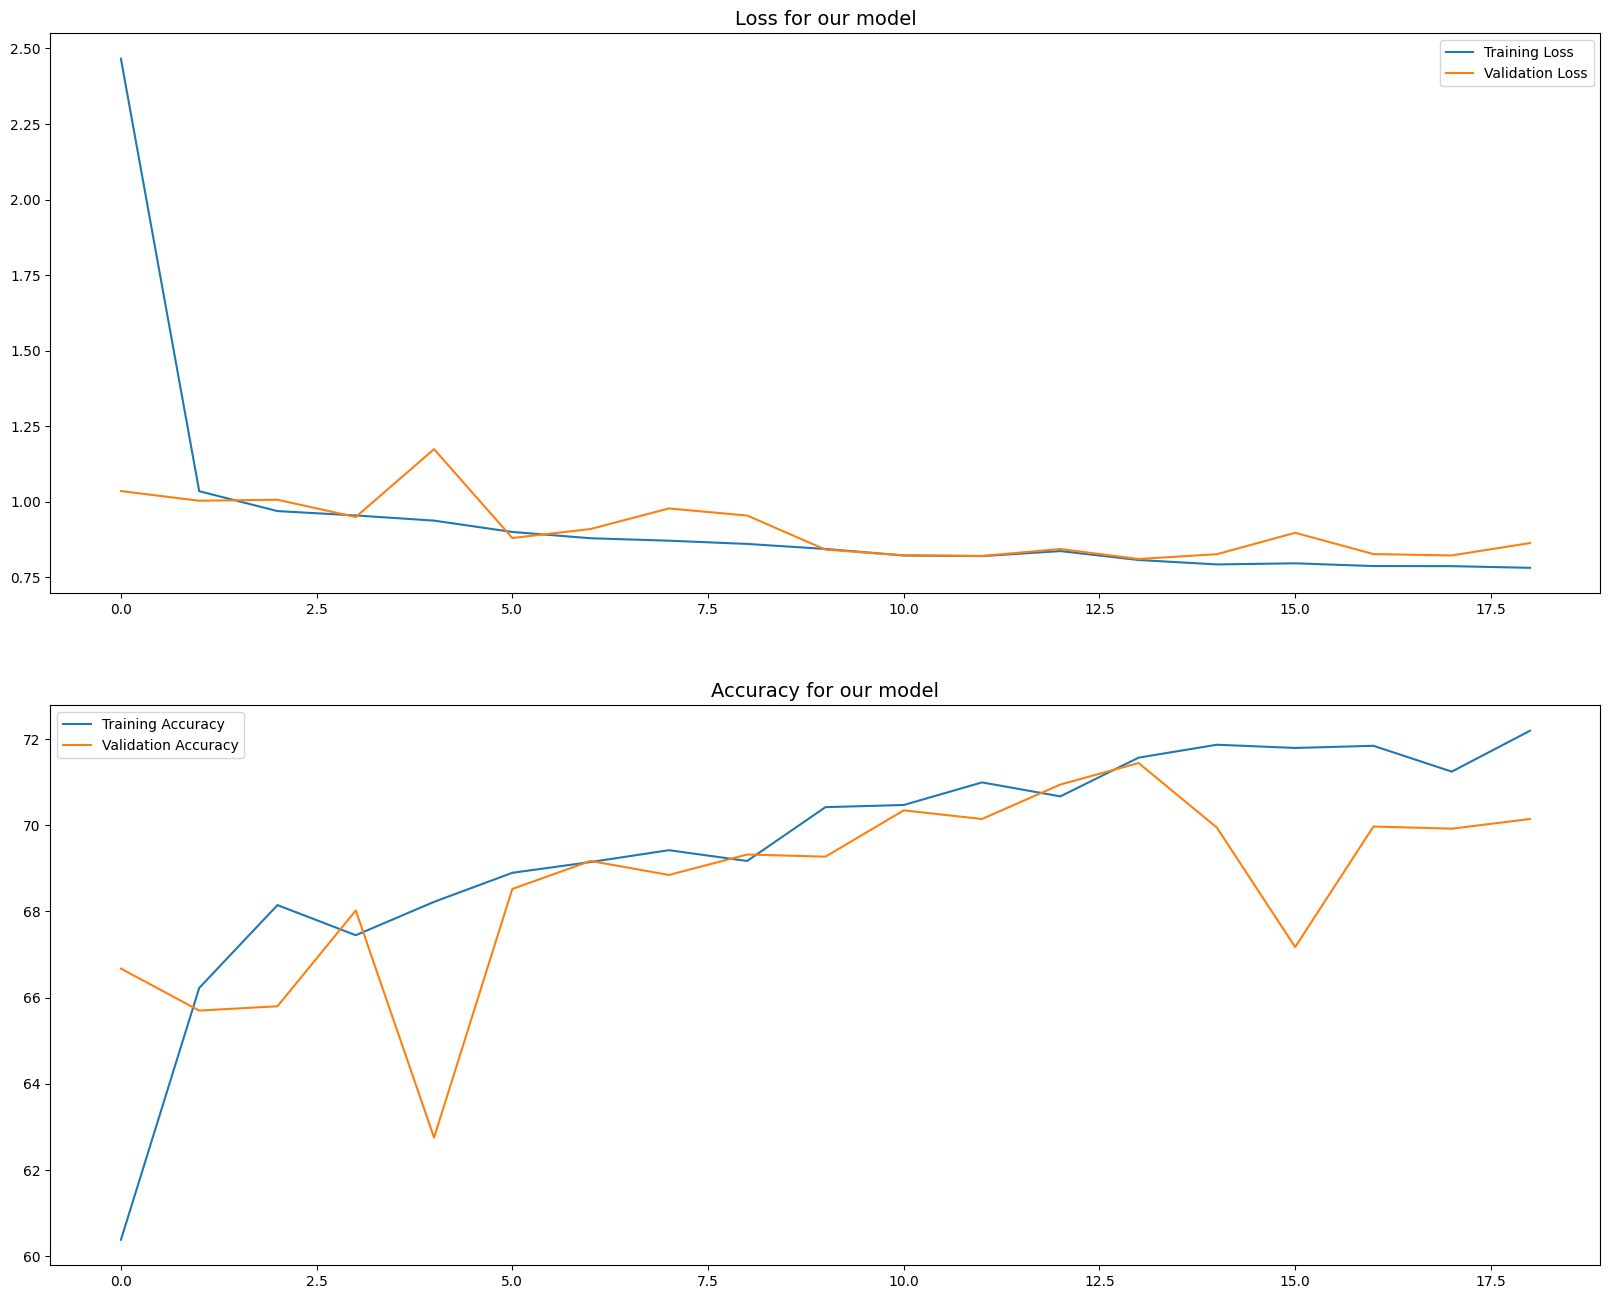

In [41]:
fig = plt.figure(num=2, figsize=(20, 16))
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss for our model', fontsize=14)
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy for our model', fontsize=14)
fig2.legend()
plt.show()

In [42]:
# Load the best model state into the CNN model
best_model_state = torch.load('CNN_model.pth', map_location='cpu')
CNN_model.load_state_dict(best_model_state)

CNN_model.to('cpu')

device = torch.device('cpu')
test_accuracy = Model_functions.test_model(CNN_model, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


<ipython-input-42-ea840f8adf42>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load('CNN_model.pth', map_location='cpu')


-------------------------------------------------------
Best model's accuracy: 70.9435846230654
-------------------------------------------------------


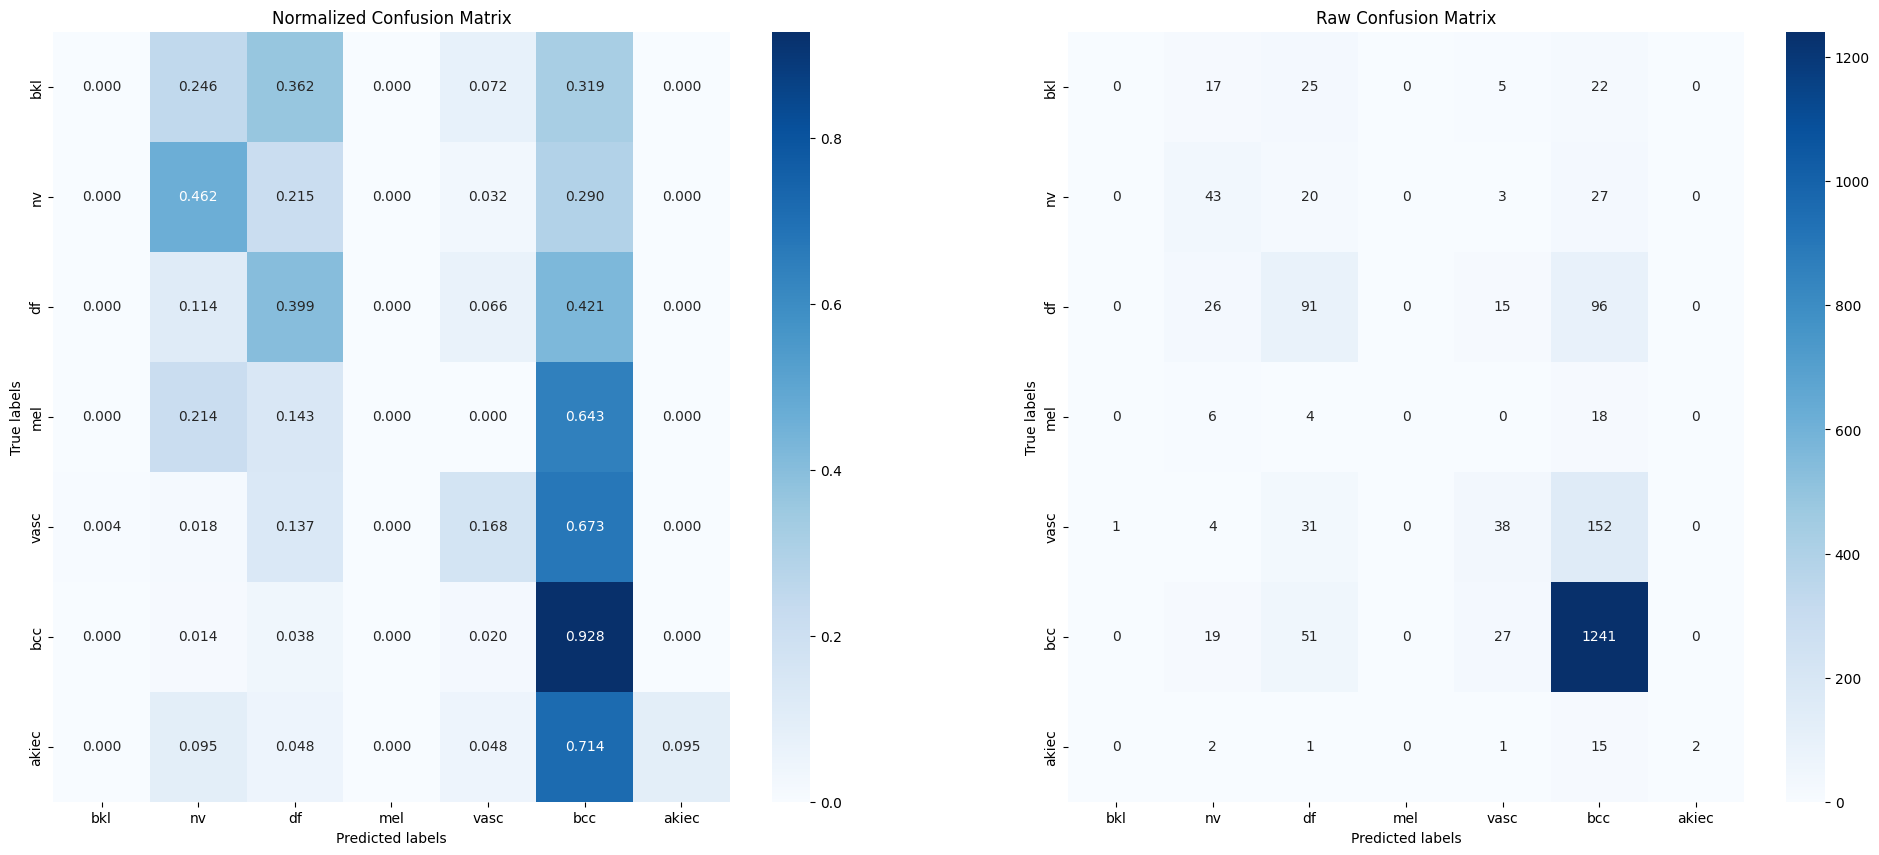

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.00      0.00      0.00        69
          nv       0.37      0.46      0.41        93
          df       0.41      0.40      0.40       228
         mel       0.00      0.00      0.00        28
        vasc       0.43      0.17      0.24       226
         bcc       0.79      0.93      0.85      1338
       akiec       1.00      0.10      0.17        21

    accuracy                           0.71      2003
   macro avg       0.43      0.29      0.30      2003
weighted avg       0.65      0.71      0.66      2003

-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
Model_functions.conf_report(CNN_model, test_loader, 'CNN_from_scratch')